Here is the problem: 

"I'm trying to compare distributions of behaviors between two populations: for population A, I have n1 individuals with counts for behaviors 1,2 and 3 (for each individual) and for population B I have n2 individuals with counts for behaviors 1, 2 and 3. I want to know if the proportion of behaviors is different between the two populations."

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import sampyl as smp
from sampyl import np
import scipy.stats as stats
import seaborn as sb
sb.set_context('notebook', font_scale=1.25)

The first step is to make some fake data to demonstrate that the model can estimate the true differences. I'm making up rates and group sizes because I don't know what you're working with here. But any numbers should work.

In [16]:
ratesA = [5., 3.7, 7.]
ratesB = [5.8, 2.1, 7.]
n1, n2 = 25, 37
dataA = np.vstack([stats.poisson(r).rvs(n1) for r in ratesA]).T
dataB = np.vstack([stats.poisson(r).rvs(n2) for r in ratesB]).T

In [17]:
dataA

array([[ 7,  3,  7],
       [ 8,  5,  7],
       [ 1,  2,  4],
       [ 5,  6,  8],
       [ 4,  4,  9],
       [ 4,  3,  6],
       [ 3,  4, 13],
       [ 4,  1,  4],
       [ 5,  6,  7],
       [ 6,  1, 10],
       [ 3,  7,  5],
       [ 4,  2, 10],
       [ 6,  4,  6],
       [ 3,  6,  3],
       [ 6,  6,  3],
       [ 7,  3,  2],
       [ 8,  6,  8],
       [ 8,  3,  7],
       [ 3,  3,  7],
       [ 7,  8,  9],
       [ 4,  8,  3],
       [ 4,  1,  4],
       [ 5,  5,  8],
       [ 2,  3,  2],
       [ 7,  0,  7]])

Here is our fake data plotted out.

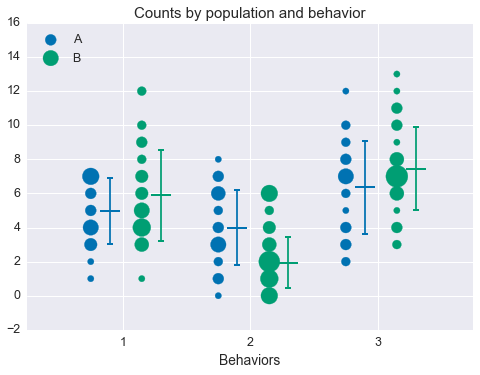

In [18]:
fig, ax = plt.subplots()
colors = sb.color_palette('colorblind', n_colors=2)
symbols = []
for j, data in enumerate([dataA, dataB]):
    counts = [np.histogram(each, range=(0, each.max()), bins=each.max()) 
              for each in data.T]
    for i, c in enumerate(counts) :
        scatter = ax.scatter(np.ones(c[1].shape)+i+j*.4, c[1], s=c[0]*40, 
                             color=colors[j])
    symbols.append(scatter)
    ax.errorbar(np.arange(1,4)+0.15+j*.4, data.mean(0), yerr=data.std(0), fmt='ok', 
                marker='_', markersize=20, markeredgewidth=2, color=colors[j])

ax.legend(symbols, ('A', 'B'), loc='upper left')
ax.set_xticks(np.arange(1,4)+0.25)
ax.set_xticklabels(['1', '2', '3'])
ax.set_xlabel('Behaviors')
ax.set_title('Counts by population and behavior')

Now the model.

Since we have count data, we will model it with Poisson distributions. We want to estimate the rates for each behavior for both groups. It would be best to make a heirarchical model. That is, we'll put priors on the rates such that for each behavior, the rates between the groups are pulled together. Our likelihood is going to look something like this, where $D$ is our data:

$$
P(D \mid \lambda^A_1, \lambda^A_2, \lambda^A_3, \lambda^B_1, \lambda^B_2, \lambda^B_3) = \mathrm{Poisson}(D \mid \lambda^A_1, \lambda^A_2, \lambda^A_3, \lambda^B_1, \lambda^B_2, \lambda^B_3)
$$

assuming everything is independent,

$$
P(D \mid \lambda^A_1, \lambda^A_2, \lambda^A_3, \lambda^B_1, \lambda^B_2, \lambda^B_3) = \mathrm{Poisson}(D^A_1 \mid \lambda^A_1) \times \mathrm{Poisson}(D^A_2 \mid \lambda^A_2)\times \cdots \times \mathrm{Poisson}(D^B_3 \mid \lambda^B_3) 
$$

As for priors, we can do something like this

\begin{align}
\lambda^A_i, \lambda^B_i &\sim \mathrm{Normal}(\mu_i, 1) \\
\mu_i &\sim \mathrm{Uniform}(0, 20) \\
\end{align}

Now I'll write a function to calculate the log-probability of the posterior distribution. Then we'll use that to sample from the posterior.

In [19]:
def logp(lamA, lamB, mu):
    if smp.outofbounds(lamA > 0, lamB > 0, mu > 0):
        return -np.inf
    
    # Log-likelihoods
    llhA = sum(smp.poisson(dataA[:, i], lamA[i]) for i in range(3))
    llhB = sum(smp.poisson(dataB[:, i], lamB[i]) for i in range(3))
    
    # Log-priors
    lam_pr = sum(smp.normal(np.array([lamA[i], lamB[i]]), m, 1)
                 for i, m in enumerate(mu))
    mu_pr = smp.uniform(mu, lower=0., upper=20.)

    return np.sum([llhA, llhB, lam_pr, mu_pr])

In [20]:
start = {'lamA': np.ones(3), 'lamB': np.ones(3),
         'mu': 2*np.ones(3)}
MAP = smp.find_MAP(logp, start)
sampler = smp.NUTS(logp, MAP)
chain = sampler.sample(1200, burn=200)

Progress: [##############################] 1200 of 1200 samples


Lets check out the chains to make sure it converged.

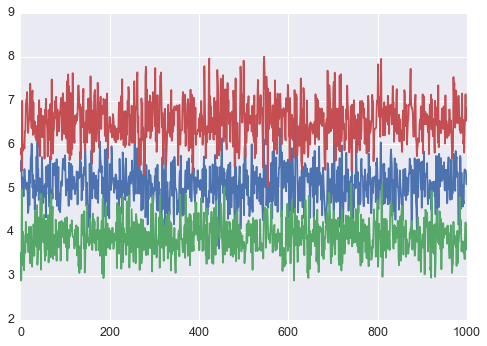

In [21]:
plt.plot(chain.lamA)

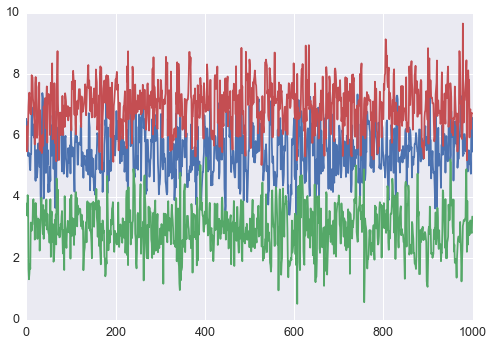

In [22]:
plt.plot(chain.mu)

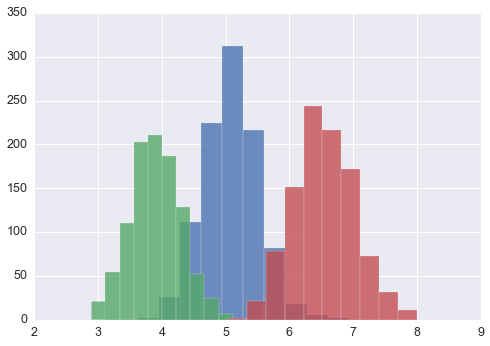

In [23]:
for each in chain.lamA.T:
    plt.hist(each, alpha=0.8)

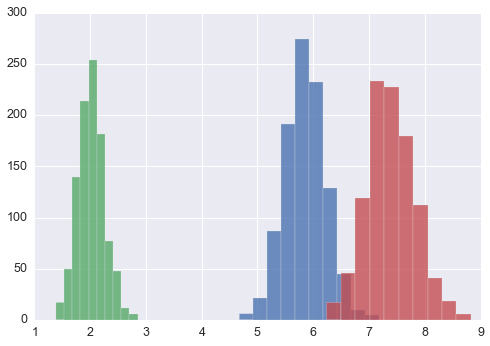

In [24]:
for each in chain.lamB.T:
    plt.hist(each, alpha=0.8)

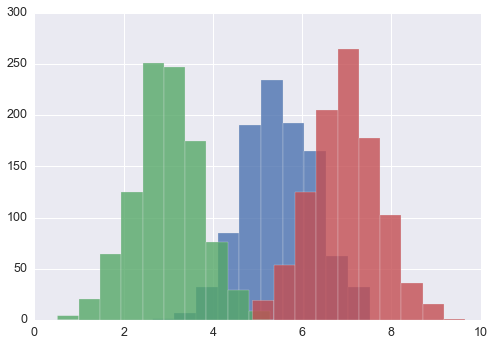

In [25]:
for each in chain.mu.T:
    plt.hist(each, alpha=0.8)

Here I'll plot the posterior distributions for the differences between the groups for each behavior. I've included the true differences as dashed lines.

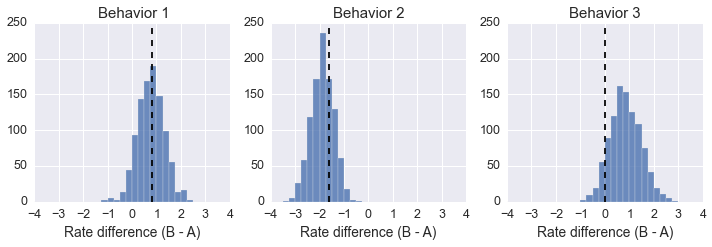

In [27]:
fig, axes = plt.subplots(figsize=(10,3.5), ncols=3)
for i, ax in enumerate(axes):
    ax.hist(chain.lamB[:,i] - chain.lamA[:,i], range=(-4,4), bins=32, alpha=0.8)
    ax.vlines(ratesB[i] - ratesA[i], 0, 250, color='k', linestyles='--')
    ax.set_title('Behavior {}'.format(i+1))
    ax.set_xlabel('Rate difference (B - A)')
fig.tight_layout()

From the posteriors, you can easily calculate means and credible intervals.